In [25]:
import pickle
import librosa
import numpy as np
from matplotlib.colors import Normalize
import scipy
import json
import librosa.display
import matplotlib.pyplot as plt

In [26]:
def visualize_data(data,title,sr):
    n_fft, hop_length, n_mfcc = 2048, 512, 13
    stft = np.abs(librosa.stft(data))
    db = librosa.amplitude_to_db(stft,ref=np.max)
    mel_spectrogram = librosa.feature.melspectrogram(y = data, sr = sr, n_fft = n_fft, hop_length = hop_length)
    db_spectrogram = librosa.power_to_db(mel_spectrogram, ref = np.max)
    mfcc = librosa.feature.mfcc(S=db_spectrogram,sr=sr,n_mfcc=n_mfcc)

    plt.figure(figsize=(12, 10)) 

    # Spectrogram
    plt.subplot(3,1,1)
    librosa.display.specshow(db, sr=sr, x_axis='time',y_axis='log',cmap='viridis')
    plt.xlabel('Time (s)')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram (dB)')

    # Mel-spectrogram
    plt.subplot(3,1,2)
    librosa.display.specshow(db_spectrogram, sr=sr, x_axis='time',y_axis='mel',fmax=8000,cmap='viridis')
    plt.xlabel('Time (s)')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram (dB)')

    # MFCC
    plt.subplot(3,1,3)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time',cmap='viridis')
    plt.yticks(np.arange(0,13,1))
    plt.xlabel('Time (s)')
    plt.ylabel('Coefficient')
    plt.colorbar()
    plt.title('MFCC')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

In [27]:
def notch_filter(data,sr,notch_freq=50,quality_factor=30):
    b, a = scipy.signal.iirnotch(notch_freq,quality_factor,sr)
    return scipy.signal.filtfilt(b,a,data)

# Feature extraction 
def visualize_audio_features(file_path, meta_data_file, sr):
    # Preprocessing
    (data, sr) = librosa.load(file_path, sr = sr, mono = True, dtype = np.float32)
    data = notch_filter(data,sr)
    
    # Extract labels from metadata files
    audio_offset = 0
    with open(meta_data_file, 'r') as file:
        meta_data = json.load(file)
    if "audio_offset" in meta_data:
        audio_offset = meta_data["audio_offset"]
    meal_start_segment, meal_end_segment = meta_data["mealStart"]-audio_offset,meta_data["mealEnd"]-audio_offset
    physical_activity_start_segment, physical_activity_end_segment = 0,0
    first_disturbance = 99999
    if "disturbances" in meta_data:
        for disturbance in meta_data["disturbances"]:
            if disturbance["start"]<first_disturbance:
                first_disturbance = disturbance["start"]
            if  disturbance["type"]=="phys_activity":
                physical_activity_start_segment, physical_activity_end_segment = disturbance["start"]-audio_offset,disturbance["end"]-audio_offset
    if first_disturbance == 99999:
        first_disturbance = meal_start_segment

    still_segment = data[:int(first_disturbance*sr)]
    meal_segment = data[int(meal_start_segment*sr):int(meal_end_segment*sr)]
    physical_activity_segment = data[int(physical_activity_start_segment*sr):int(physical_activity_end_segment*sr)]

    visualize_data(still_segment[int(15*sr):int(45*sr)],"Audio features - Still",sr)
    visualize_data(meal_segment[:int(30*sr)],"Audio features - Meal",sr)
    visualize_data(physical_activity_segment[:int(30*sr)],"Audio features - Physical activity",sr)


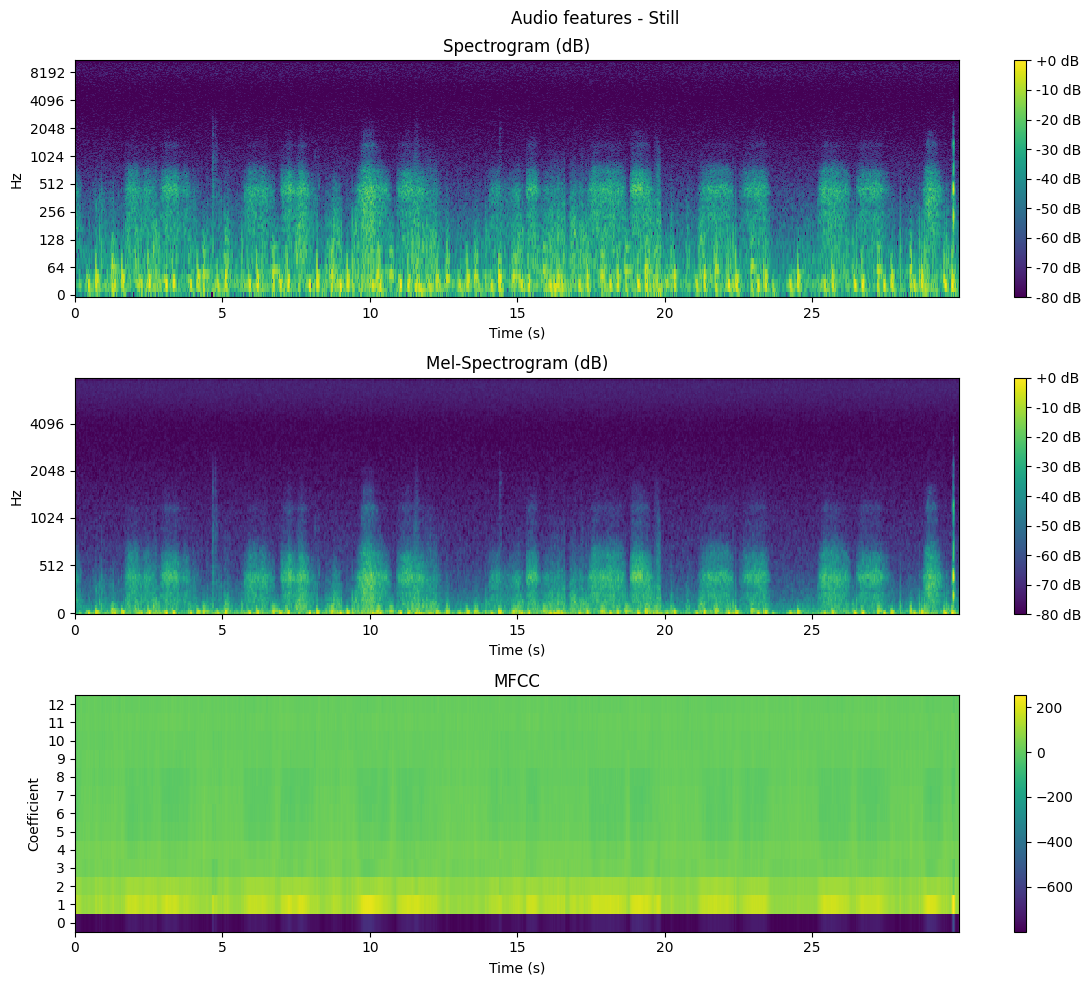

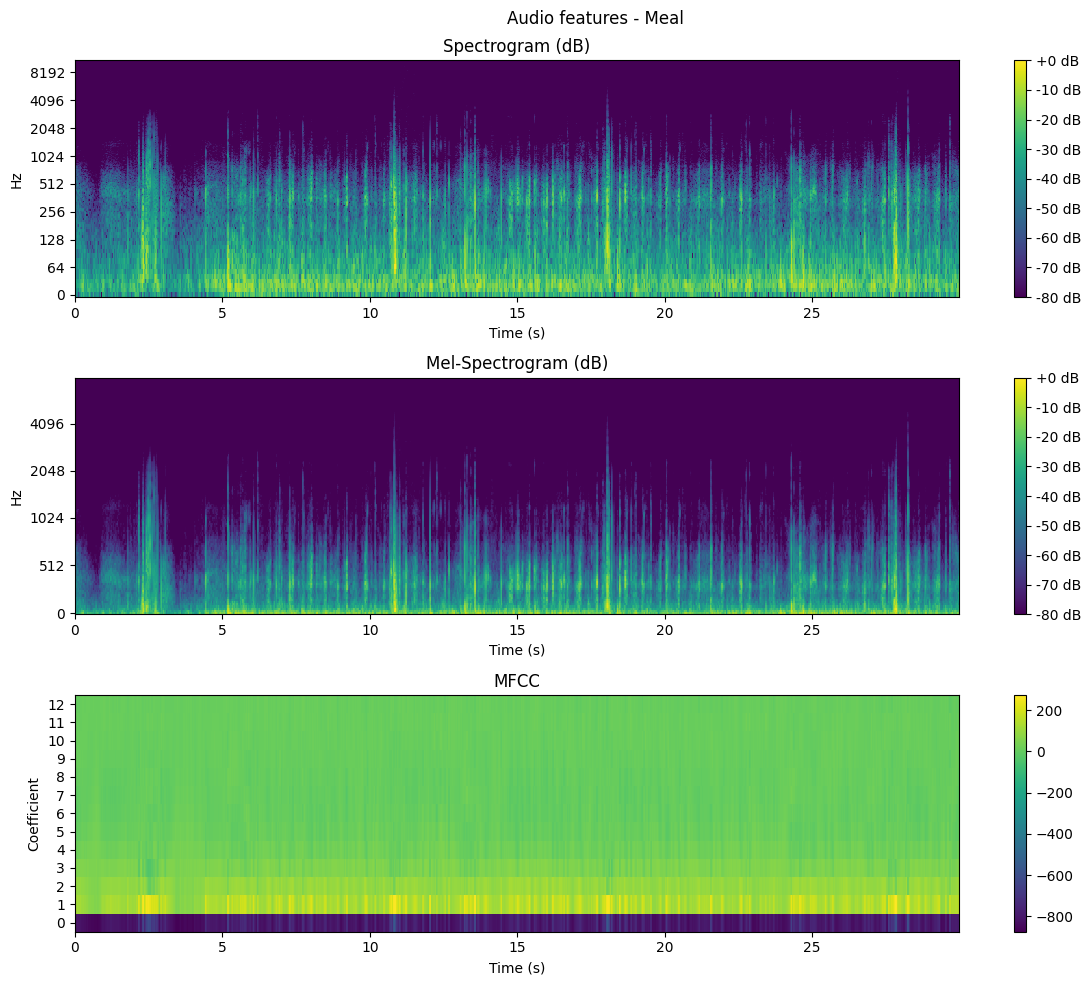

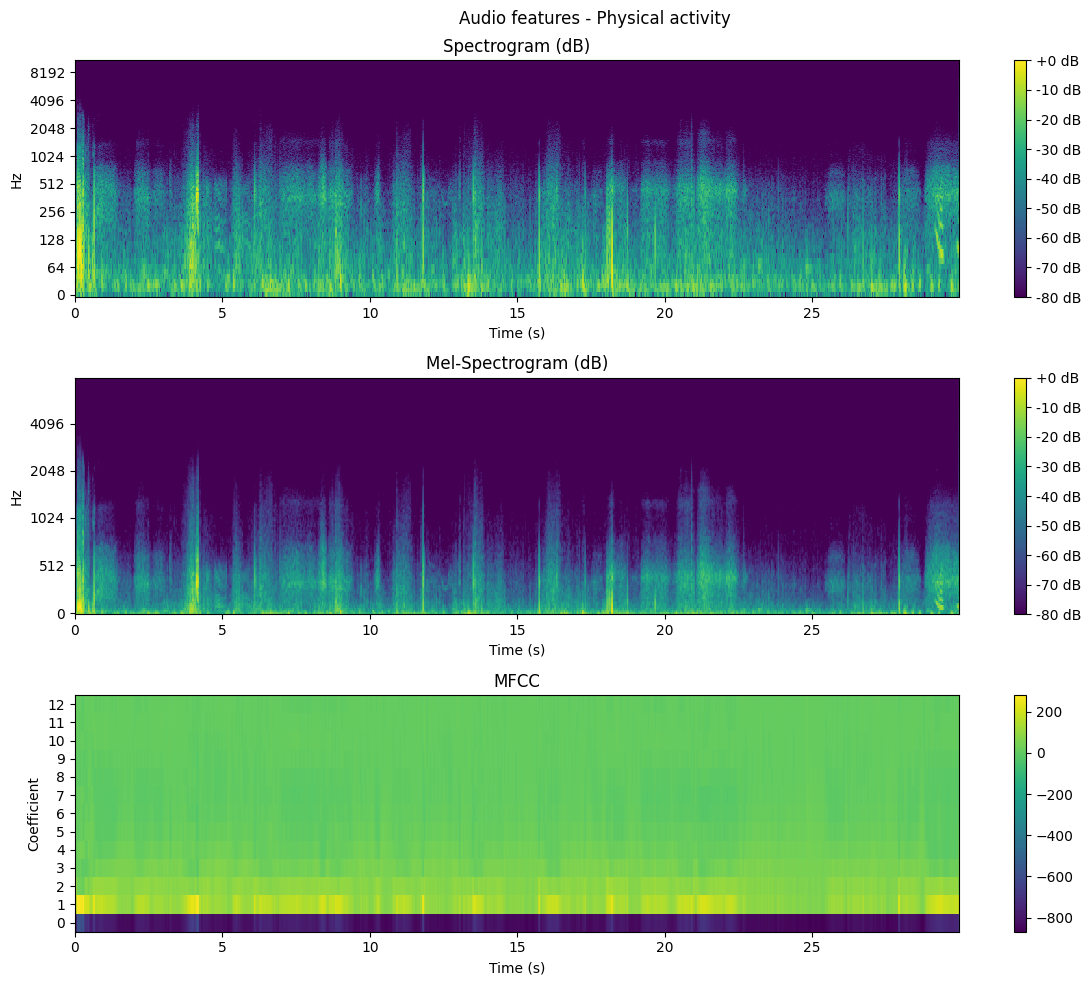

In [28]:
visualize_audio_features("..\\Data\\2024-2025\\eGAR\\hHzwap\\pos1.WAV","..\\Data\\2024-2025\\eGAR\\hHzwap\\hHzwap.json",22050)